# TrainFinalModel
Important: Use Python 3.8, not 3.10! Prophet is not compatible with 3.8 :(

In [1]:
import math
from datetime import datetime
from datetime import timedelta
import pandas as pd
from pathlib import Path
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
from prophet.serialize import model_to_json, model_from_json
import math

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Switzerland
COVID_START = datetime(2020, 3, 1).date()
# https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-84127.html
# date taken as the second easing of restrictions during 2021
COVID_END = datetime(2021, 6, 1).date()

MODEL_PATH = Path("../data/model/")
TRAIN_DATA_PATH = Path('../data/consumption/final_train.parquet')
DATA_PATH_2022 = Path('../data/consumption/2022.parquet')

MODEL_NAME = "totalconsumption_rolling7day.json"
CONSUMPTION_EXPR = "NE5Consumption + NE7Consumption" # i.e. "NE5Consumption + NE7Consumption", "NE5Consumption", "NE7Consumption"
ROLLING_WINDOW = 7
CONFIDENCE_INTERVAL = 0.95
USE_WEEK_SEASONALITY = False
USE_HOLIDAYS = False

In [3]:
"""
    return (spark.read.format("parquet").load(path)
                                      .withColumn("y", f.expr(CONSUMPTION_EXPR))
                                      .withColumn("CosYearTemp", f.expr("Temperature * cos(dayofyear(Date) * 2 * pi() / 365)"))
                                      .withColumn("SinYearTemp", f.expr("Temperature * sin(dayofyear(Date) * 2 * pi() / 365)"))
                                      .selectExpr("Date as ds", "y", "CosYearTemp", "SinYearTemp")
                                      .orderBy("ds")
         ).toPandas().rolling(ROLLING_WINDOW, on="ds").mean().dropna()[:-ROLLING_WINDOW]
"""

train = pd.read_parquet(TRAIN_DATA_PATH, engine='pyarrow')
train['Date'] = pd.to_datetime(train['Date'])
train['y'] = train['NE5Consumption'] + train['NE7Consumption']
train['CosYearTemp'] = train.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train['SinYearTemp'] = train.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train.rename(columns={'Date': 'ds'}, inplace=True)
train = train.sort_values('ds')
train = train.rolling(ROLLING_WINDOW, on='ds').mean().dropna()[:-ROLLING_WINDOW]

In [4]:
# add covid as a one-off holiday
covid = pd.DataFrame([
    {'holiday': 'covid', 'ds': COVID_START, 'lower_window': 0, 'ds_upper': COVID_END}
])

covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

In [5]:
m = Prophet(holidays = covid, weekly_seasonality = USE_WEEK_SEASONALITY, changepoint_prior_scale = 0.005, changepoint_range=1, interval_width=CONFIDENCE_INTERVAL, uncertainty_samples = 10000)

if USE_HOLIDAYS:
    m.add_country_holidays(country_name='CH')
  
m.add_regressor("CosYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")
m.add_regressor("SinYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.7443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15285.6    0.00371214       1775.21           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15346.5    0.00017044       1105.33       0.247       0.247      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15362.6   0.000330477       1304.51           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15367.3   0.000111607       679.524           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     486       15369.1   7.12918e-05       857.816   8.989e-08       0.001      626  LS failed, Hessian reset 
     499       15369.1   6.13444e-06    

In [6]:
forecastTrain = m.predict(train)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

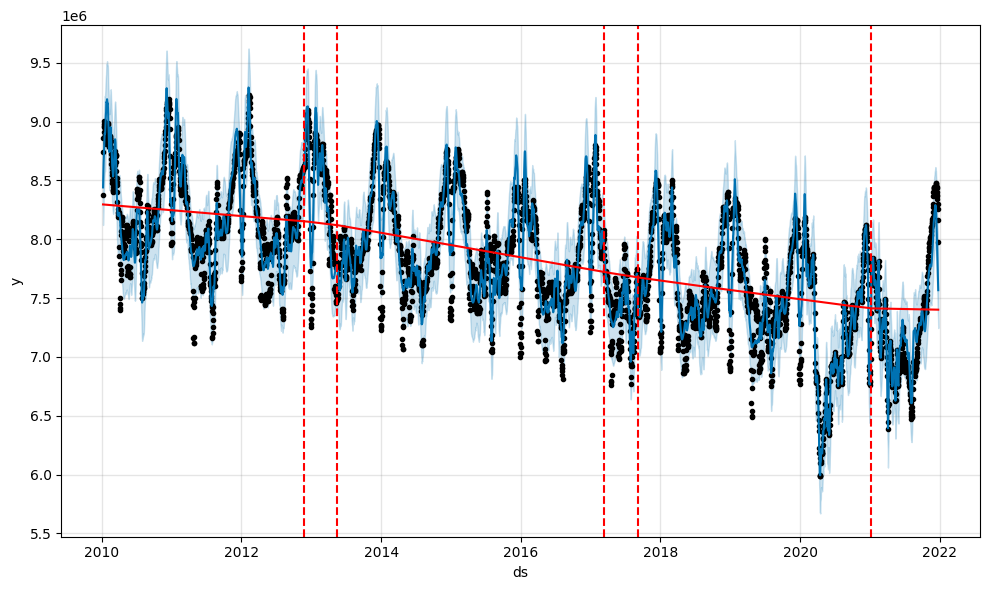

In [7]:
fig = m.plot(forecastTrain)
a = add_changepoints_to_plot(fig.gca(), m, forecastTrain)

In [8]:
mse = mean_squared_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())
mse

27105636415.517555

In [9]:
rmse = math.sqrt(mse)
rmse

164637.89483444433

In [10]:
mean_absolute_percentage_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())

0.014911358519010551

In [11]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,CosYearTemp,additive,-4.509196,-47348.513333,-47348.513333,-47348.513333
1,SinYearTemp,additive,-1.334093,-20920.625980,-20920.625980,-20920.625980


In [12]:
plotData = pd.DataFrame(
  {
    "Actual": train["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=train["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

In [13]:
def plot(data):
  fig, ax = plt.subplots()
  fig.set_size_inches(12, 8)
  fig.patch.set_facecolor('white')
  ax.plot(data.index, data["Actual"])
  ax.fill_between(data.index, data["PredictedHigh"], data["PredictedLow"], color='orange', alpha=.2)

In [14]:
plotData.head()

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2010-01-07,8.376166e+06,8.440218e+06,8.760919e+06,8.121035e+06
2010-01-08,8.739652e+06,8.521786e+06,8.852068e+06,8.209267e+06
2010-01-09,8.862974e+06,8.593714e+06,8.921769e+06,8.267445e+06
2010-01-10,8.909584e+06,8.649933e+06,8.972672e+06,8.325571e+06
2010-01-11,8.956253e+06,8.696771e+06,9.013868e+06,8.377001e+06


In [ ]:
plot(plotData)

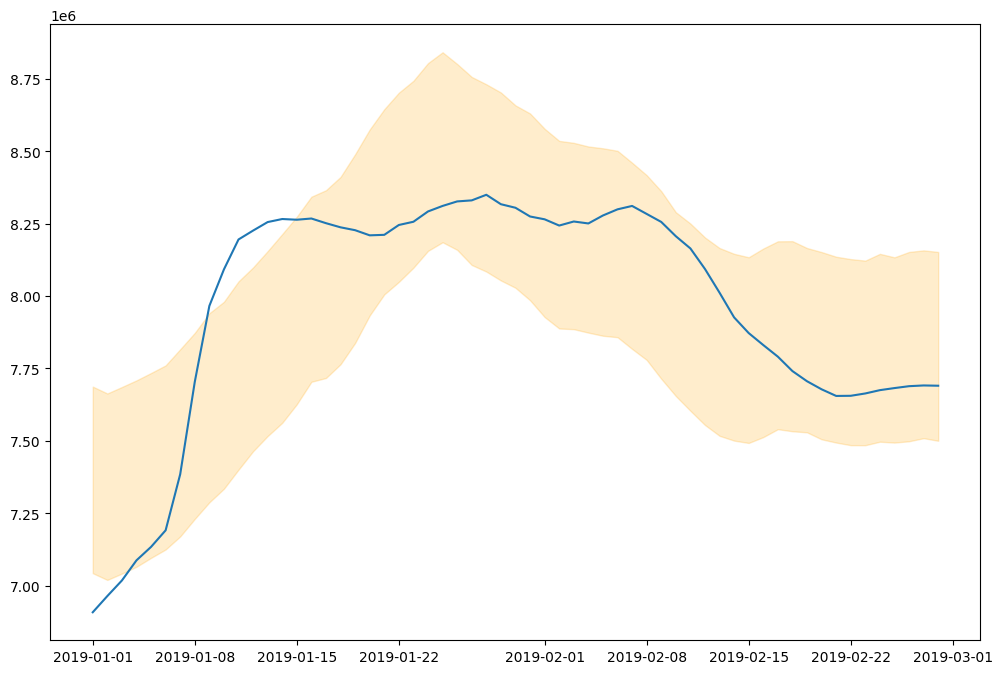

In [15]:
plot(plotData[(plotData.index >= datetime(2019, 1, 1)) & (plotData.index < datetime(2019, 3, 1))])

In [16]:
with open(MODEL_PATH / MODEL_NAME, 'w') as fout:
    fout.write(model_to_json(m))

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


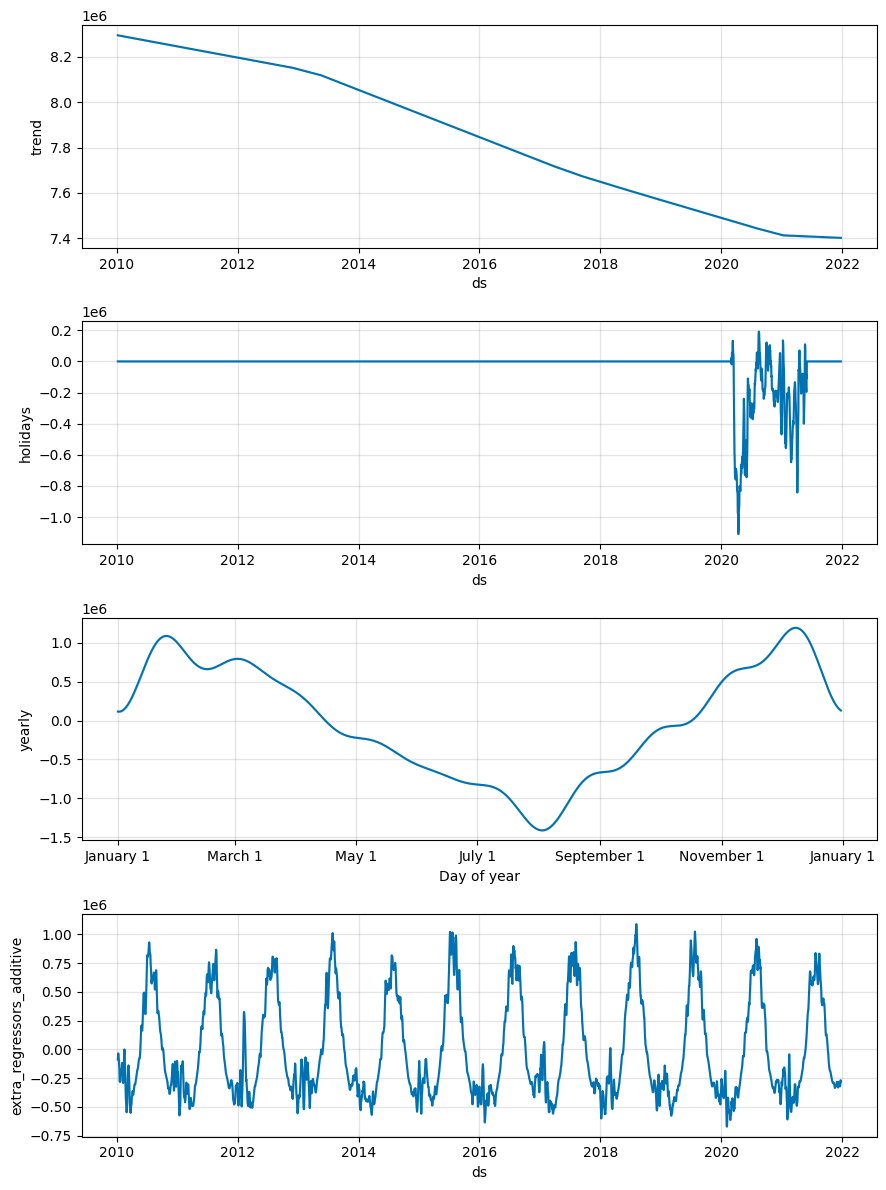

In [17]:
fig = m.plot_components(forecastTrain)

## 2022 test

In [18]:
df_2022 = pd.read_parquet(DATA_PATH_2022, engine='pyarrow')
df_2022['Date'] = pd.to_datetime(df_2022['Date'])
df_2022['y'] = df_2022['NE5Consumption'] + df_2022['NE7Consumption']
df_2022['CosYearTemp'] = df_2022.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
df_2022['SinYearTemp'] = df_2022.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
df_2022.rename(columns={'Date': 'ds'}, inplace=True)
df_2022 = df_2022.sort_values('ds')
df_2022 = df_2022.rolling(ROLLING_WINDOW, on='ds').mean().dropna()

forecastTrain = m.predict(df_2022)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

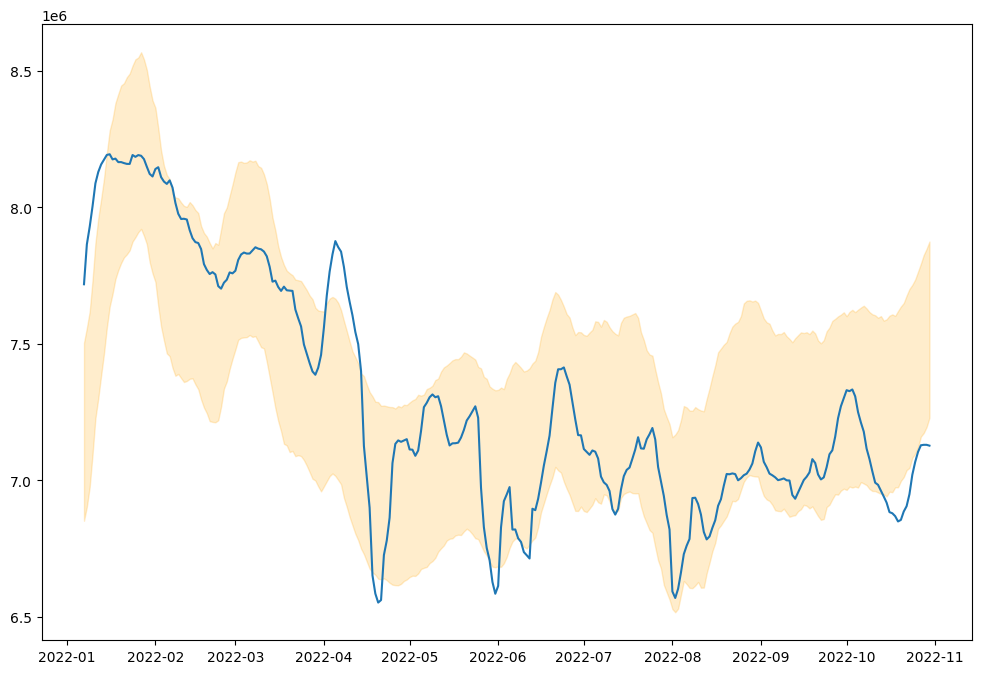

In [19]:
plotData = pd.DataFrame(
  {
    "Actual": df_2022["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=df_2022["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

plot(plotData)

In [20]:
plotData

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2022-01-07,7.718273e+06,7.179591e+06,7.503620e+06,6.851621e+06
2022-01-08,7.864317e+06,7.230765e+06,7.557912e+06,6.903136e+06
2022-01-09,7.928982e+06,7.293935e+06,7.618544e+06,6.976043e+06
2022-01-10,8.004618e+06,7.415755e+06,7.733945e+06,7.095317e+06
2022-01-11,8.088217e+06,7.547512e+06,7.869311e+06,7.227190e+06
...,...,...,...,...
2022-10-26,7.103914e+06,7.444641e+06,7.764354e+06,7.121356e+06
2022-10-27,7.128246e+06,7.470576e+06,7.793538e+06,7.160083e+06
2022-10-28,7.129971e+06,7.496932e+06,7.825657e+06,7.173280e+06


In [21]:
plotData.iloc[18:30]

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2022-01-25,8.185206e+06,8.215041e+06,8.542535e+06,7.890657e+06
2022-01-26,8.191657e+06,8.233699e+06,8.549216e+06,7.909107e+06
2022-01-27,8.189147e+06,8.249737e+06,8.568384e+06,7.921138e+06
2022-01-28,8.176745e+06,8.219083e+06,8.542138e+06,7.895759e+06
2022-01-29,8.148948e+06,8.181882e+06,8.503928e+06,7.865211e+06
2022-01-30,8.122620e+06,8.124025e+06,8.442620e+06,7.798988e+06
2022-01-31,8.113260e+06,8.081960e+06,8.391726e+06,7.758157e+06
2022-02-01,8.140648e+06,8.043217e+06,8.365181e+06,7.726751e+06
2022-02-02,8.147229e+06,7.965671e+06,8.290467e+06,7.637808e+06
